In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [2]:
"""
This notebook is to illustrate the Transformer architecture.
Steps are followed by my article post: 
https://waylandzhang.github.io/en/let-s-code-llm.html
"""

'\nThis notebook is to illustrate the Transformer architecture.\nSteps are followed by my article post: \nhttps://waylandzhang.github.io/en/let-s-code-llm.html\n'

In [3]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
#device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.
device = 'cpu'

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [4]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('data/sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    

In [5]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(tokenized_text.shape)
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
torch.Size([77919])
The maximum value in the tokenized text is: 100069


In [6]:
# Illustration purpose
print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]
print(encoding.decode([627, 1383, 88861, 279,1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449]))
print(encoding.decode([23097, 6946, 403]))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing
.
By mastering the art of identifying underlying motivations and desires, we equip ourselves with
 Rap videosport


In [7]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [8]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)
print(x_batch)

torch.Size([4, 16]) torch.Size([4, 16])
tensor([[  279,  6763,  1920,    13,   578,  5845,   311, 13750, 19570,   279,
           907,   323,  7720,   315,  1057,  3956],
        [ 3495, 14955,    11,   477,  5064, 23146,   430,  9788,   279, 66732,
           315,   701, 10209,    13,  3296, 32644],
        [38769, 10742,    11, 20958,   264,  6928, 19451,    11, 11125, 64784,
            11,   323, 56501, 54111,   439,  6975],
        [43496,   872,  8830,   719,  1101,  3727,   279,  6130,  2733,  6755,
           323, 16365,   627, 29831, 19682,  5900]])


In [9]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our x batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))
print("Our y batches:\n", pd.DataFrame(y_batch.data.detach().cpu().numpy()))

Our x batches:
       0      1     2      3     4      5      6      7      8      9    10     11     12     13     14     15
0    279   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956
1   3495  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644
2  38769  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    439   6975
3  43496    872  8830    719  1101   3727    279   6130   2733   6755  323  16365    627  29831  19682   5900
Our y batches:
       0     1      2     3      4      5      6      7      8    9      10     11     12     13     14     15
0   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956    477
1  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644   1521
2  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111

In [10]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100070, 64)


In [11]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data)

x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [12]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("position = \n", position)
print("div_term = \n", div_term )
print(div_term.shape)

#pos_div=position*div_term
#print("pd = \n", pos_div)
#print(pos_div.shape)

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

position = 
 tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.]])
div_term = 
 tensor([1.0000e+00, 7.4989e-01, 5.6234e-01, 4.2170e-01, 3.1623e-01, 2.3714e-01,
        1.7783e-01, 1.3335e-01, 1.0000e-01, 7.4989e-02, 5.6234e-02, 4.2170e-02,
        3.1623e-02, 2.3714e-02, 1.7783e-02, 1.3335e-02, 1.0000e-02, 7.4989e-03,
        5.6234e-03, 4.2170e-03, 3.1623e-03, 2.3714e-03, 1.7783e-03, 1.3335e-03,
        1.0000e-03, 7.4989e-04, 5.6234e-04, 4.2170e-04, 3.1623e-04, 2.3714e-04,
        1.7783e-04, 1.3335e-04])
torch.Size([32])
Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


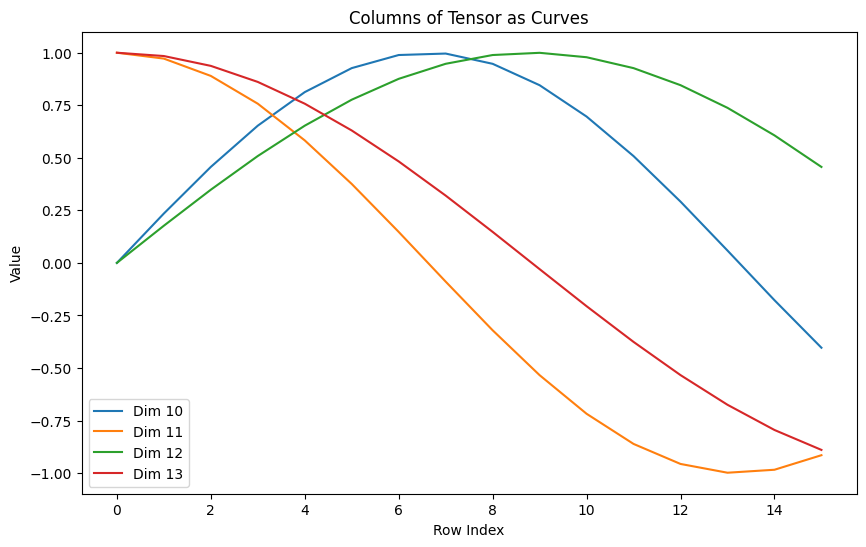

In [13]:
#dispaly each dimenition wave.
simple_postion_table = position_encoding_lookup_table[0,:,:]
# Step 2: Convert tensor to numpy array for plotting
tensor_np = simple_postion_table.numpy()

# Step 3: Plot each column as a separate curve
plt.figure(figsize=(10, 6))
#for i in range(tensor_np.shape[1]):
start_dim = 10
for i in range(start_dim, start_dim + 4):
    plt.plot(tensor_np[:, i], label=f'Dim {i}')

# Step 4: Add titles and labels
plt.title('Columns of Tensor as Curves')
plt.xlabel('Row Index')
plt.ylabel('Value')
plt.legend()
plt.show()

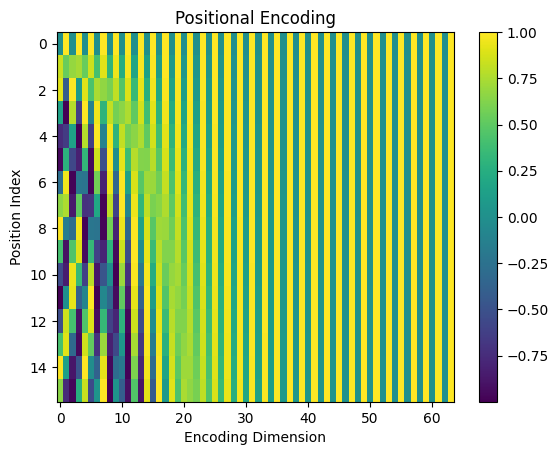

In [14]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [15]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.399742,-0.206918,0.327990,0.748870,0.531874,0.751807,0.351938,0.610762,0.129977,-0.207580,...,-0.547752,2.515671,1.223743,1.833670,-0.404194,1.563555,0.591292,0.275255,1.670105,0.758279
1,1.407957,-0.561974,2.393893,0.377252,1.083746,0.138066,-0.334590,1.670161,0.329176,2.342795,...,0.873984,2.226714,0.794747,1.598629,0.884658,1.032520,1.353795,1.059697,1.172643,1.527427
2,0.482819,1.301215,0.653670,-0.846175,0.628521,1.126829,-0.102938,-0.636202,0.428573,0.553769,...,-0.934116,2.145729,-1.913517,0.552654,0.597746,2.673483,-1.969119,1.397835,-0.438208,0.437077
3,0.851059,0.379319,0.070685,0.910763,-1.117662,0.325378,0.947827,0.472564,0.516017,0.790074,...,0.072798,0.264451,0.070916,-1.744750,1.088080,0.002188,0.715526,-0.357311,1.604357,1.920290
4,-2.720048,-0.354717,0.272903,-0.906938,0.932237,-1.449321,-0.226828,-1.203768,2.488952,2.130765,...,0.533600,0.432145,-2.389682,0.913403,0.066965,1.655225,0.625080,0.236625,-0.692241,0.992275
5,-0.147775,0.718796,0.559903,-0.004127,-0.690035,-0.998508,0.331355,-1.222723,0.836060,-1.353497,...,-0.044886,-0.201054,-0.926252,1.322522,0.587324,1.108183,-1.652407,2.918813,0.942309,1.584330
6,0.038134,3.066611,-1.069607,0.424900,-1.142844,-2.948736,0.505219,-0.617680,1.280667,-0.168857,...,0.202646,1.051821,1.306703,1.517673,0.050767,1.044631,1.347860,0.678610,-0.477987,0.833080
7,-1.368717,2.010294,-1.177933,1.943613,0.931115,-2.610583,-0.812628,-1.958096,2.302625,0.242536,...,-2.336618,1.190780,-0.052987,3.281737,-0.415515,0.198294,-1.392472,2.863094,-0.392633,0.868254
8,3.896336,-0.053480,-1.065470,1.569054,-1.767442,-0.238040,-1.386770,-0.574759,0.118923,-1.069920,...,3.366446,0.203255,1.759607,2.526687,-0.652322,2.660683,0.966853,1.618786,1.664013,2.768385
9,1.811860,-2.118048,0.777184,0.642304,-0.407949,0.093468,-0.256171,-1.183092,0.421236,-2.164224,...,-0.543957,2.515664,1.226589,1.833666,-0.402059,1.563552,0.592893,0.275254,1.671305,0.758279


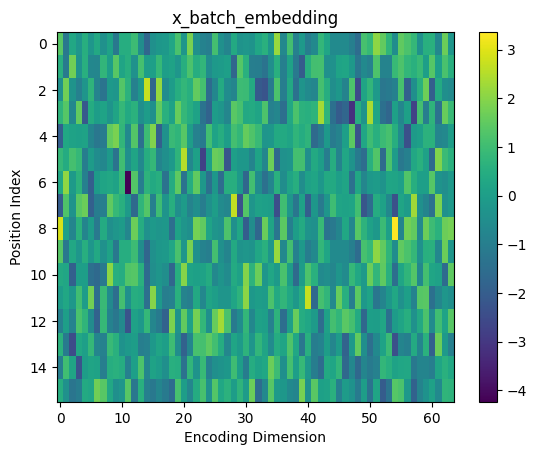

In [16]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("x_batch_embedding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

x_batch_embedding_np = x_batch_embedding[0].detach().cpu().numpy()
visualize_pe(x_batch_embedding_np)

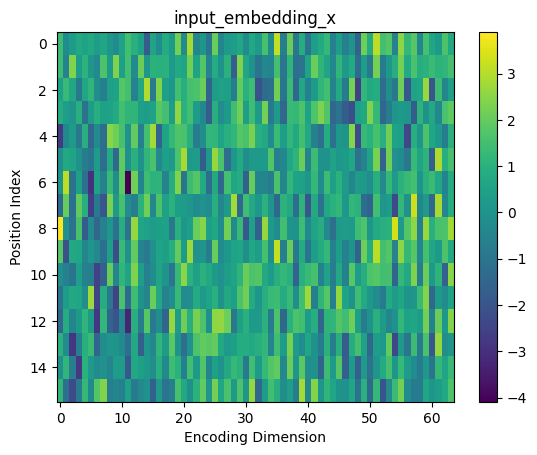

In [17]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("input_embedding_x")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

input_embedding_x_np = input_embedding_x[0].detach().cpu().numpy()
visualize_pe(input_embedding_x_np)

In [18]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [37]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(query) #[4, 16, 64]
Q_B1 = Q[0,:,:]

Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K_B1 = K[0,:,:]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.165560 -1.006899 -0.474252 -0.629691 -0.800182 -0.153174  0.440636  1.096891 -1.639451  0.003812  0.422917 -0.825343 -0.429818 -1.271212  0.090107  0.344258
1  0.214548 -0.110679 -0.064984 -0.184515 -0.583444 -0.171890 -1.244689  0.184259  0.278665 -0.505992 -1.233088  0.335234 -0.266916  0.262088 -0.349562  0.068045
2 -0.436739 -1.287984  0.426888  0.961051 -0.801031 -0.016087 -0.823747 -0.513535 -0.950310 -0.459472 -0.899308  0.085084 -0.778880  0.508962  0.751745 -0.225357
3  0.405927  0.802259 -0.217938  0.398843 -0.299505  1.651993 -0.873555  0.618109  0.383322 -0.044058 -0.021004  0.007719  0.530207 -0.046535  0.550610  0.153119
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.794040 -0.777482 -1.044

In [42]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

Q_B1_H1 = Q[0,0,:,:]
K_B1_H1 = K[0,0,:,:]

print(pd.DataFrame(Q_B1.detach().cpu().numpy()))
print(pd.DataFrame(Q_B1_H1.detach().cpu().numpy()))

          0         1         2         3         4         5         6         7         8         9   ...        54        55        56        57        58        59        60        61        62        63
0   0.165560 -1.006899 -0.474252 -0.629691 -0.800182 -0.153174  0.440636  1.096891 -1.639451  0.003812  ... -0.873555  0.618109  0.383322 -0.044058 -0.021004  0.007719  0.530207 -0.046535  0.550610  0.153119
1   0.794040 -0.777482 -1.044919 -0.990273 -1.238365 -1.081400  0.983929  0.599103 -0.988020 -0.276452  ... -0.596461 -0.047878  0.023586  0.484500  0.410697  0.126574  0.229650  0.283467  0.539415 -0.022946
2   0.240786  0.410453 -0.289506 -0.983507 -1.551320 -0.781868 -0.544682  0.376780 -0.704613 -0.119311  ...  0.872038 -0.266064 -0.081601 -0.160133  0.958197  0.081074  0.505232  0.105417  0.944231 -0.164638
3   0.333064 -0.761574 -0.252921 -0.360830 -1.246392 -1.273926  0.393376 -0.113349 -0.969833 -0.251602  ...  0.708767  0.806080  0.223863  0.130372 -0.220907  0.195520 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.144698,-0.288894,0.292603,0.218625,-0.174081,-0.175564,0.224630,0.315288,-0.294342,0.175313,-0.041475,0.646816,-0.925689,0.678691,-0.416961,-0.579105
1,-0.058350,-0.869092,-0.120730,0.285301,-0.076567,0.279562,0.291363,0.446630,-0.973418,0.005116,-0.158295,0.626393,-1.837572,0.676254,-0.776665,-1.419852
2,-0.488896,-0.493404,-0.338871,0.252143,-0.067523,0.641825,0.111798,0.577994,0.085726,-0.517022,-0.235277,-0.198591,-1.567807,0.097400,-0.793210,-0.891592
3,0.050049,0.015923,-0.083248,0.088275,0.388972,0.064235,0.224227,-0.122441,-0.437620,0.036668,-0.233810,0.856747,-0.855484,0.457549,-0.392983,-0.801224
4,-0.623301,-0.149627,0.584936,-0.613356,0.016194,-0.177256,0.471698,0.866466,1.223140,-0.647056,-0.318572,0.292781,-0.081500,0.220563,-0.024737,-0.453478
5,0.342635,-0.090034,0.998000,0.167386,0.658590,0.449861,1.165314,0.930861,0.605285,0.571213,0.858460,0.588438,0.285727,0.019787,0.222843,-0.059778
6,-0.136621,-0.556502,0.473883,0.509188,0.567063,0.513569,0.098732,-0.169839,-0.338649,0.210748,0.716522,0.592600,-0.559104,0.432861,-0.035492,0.006996
7,-0.913821,-0.116069,0.163589,-0.512896,0.227289,0.041829,-0.199697,0.380585,-0.490428,-1.022224,0.332610,0.312565,0.344663,-0.300685,-0.286513,-0.686143
8,0.767636,0.262972,1.021607,0.727599,-0.423034,-0.103180,-0.071092,-0.558999,-1.687176,0.929976,0.353265,0.972940,-0.326978,0.546353,-0.159661,0.593412
9,0.267590,-0.089583,0.570785,0.404128,-0.345082,-0.019615,0.273352,0.413137,-0.527080,0.238378,-0.378896,0.374530,-0.976263,0.489713,-0.509832,-0.032813


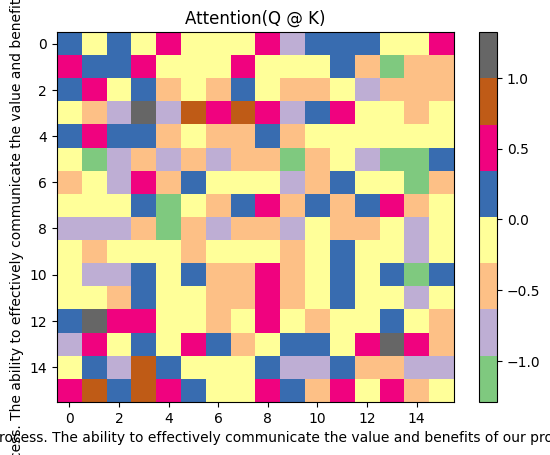

In [46]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[0, 0].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.144698,-0.288894,0.292603,0.218625,-0.174081,-0.175564,0.224630,0.315288,-0.294342,0.175313,-0.041475,0.646816,-0.925689,0.678691,-0.416961,-0.579105
1,-0.058350,-0.869092,-0.120730,0.285301,-0.076567,0.279562,0.291363,0.446630,-0.973418,0.005116,-0.158295,0.626393,-1.837572,0.676254,-0.776665,-1.419852
2,-0.488896,-0.493404,-0.338871,0.252143,-0.067523,0.641825,0.111798,0.577994,0.085726,-0.517022,-0.235277,-0.198591,-1.567807,0.097400,-0.793210,-0.891592
3,0.050049,0.015923,-0.083248,0.088275,0.388972,0.064235,0.224227,-0.122441,-0.437620,0.036668,-0.233810,0.856747,-0.855484,0.457549,-0.392983,-0.801224
4,-0.623301,-0.149627,0.584936,-0.613356,0.016194,-0.177256,0.471698,0.866466,1.223140,-0.647056,-0.318572,0.292781,-0.081500,0.220563,-0.024737,-0.453478
5,0.342635,-0.090034,0.998000,0.167386,0.658590,0.449861,1.165314,0.930861,0.605285,0.571213,0.858460,0.588438,0.285727,0.019787,0.222843,-0.059778
6,-0.136621,-0.556502,0.473883,0.509188,0.567063,0.513569,0.098732,-0.169839,-0.338649,0.210748,0.716522,0.592600,-0.559104,0.432861,-0.035492,0.006996
7,-0.913821,-0.116069,0.163589,-0.512896,0.227289,0.041829,-0.199697,0.380585,-0.490428,-1.022224,0.332610,0.312565,0.344663,-0.300685,-0.286513,-0.686143
8,0.767636,0.262972,1.021607,0.727599,-0.423034,-0.103180,-0.071092,-0.558999,-1.687176,0.929976,0.353265,0.972940,-0.326978,0.546353,-0.159661,0.593412
9,0.267590,-0.089583,0.570785,0.404128,-0.345082,-0.019615,0.273352,0.413137,-0.527080,0.238378,-0.378896,0.374530,-0.976263,0.489713,-0.509832,-0.032813


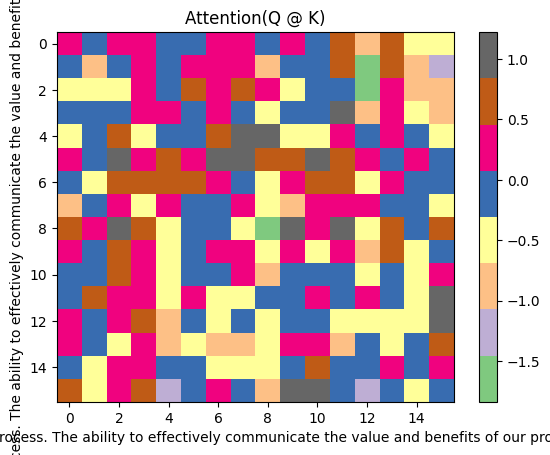

In [45]:
# Calculate the attention score
attention_score_h1 = torch.matmul(Q_B1_H1, K_B1_H1.T) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score_h1.detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score_h1.detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,1.123528,0.464093,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,1.040623,0.605708,0.119165,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.900045,0.596818,0.359724,0.836026,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,1.061119,1.158659,0.633724,-0.320907,0.383561,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.071058,0.273445,0.044782,0.250272,-0.114290,0.121239,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.897961,1.322748,0.553525,0.079147,0.502846,-0.506932,0.223247,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.529123,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.935247,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035515,-0.006277,0.174739,0.899135,-inf,-inf,-inf,-inf,-inf,-inf


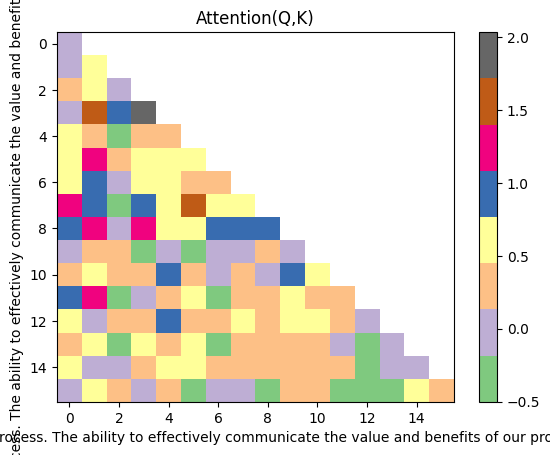

In [22]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [23]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.659133,0.340867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.488936,0.316498,0.194566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.306845,0.226584,0.178756,0.287816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.284609,0.313769,0.185624,0.071457,0.144541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.159313,0.195051,0.155182,0.190583,0.132360,0.167512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.195804,0.299437,0.138751,0.086341,0.131894,0.048049,0.099724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.100501,0.213640,0.183524,0.068726,0.121962,0.092737,0.131933,0.086976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.176701,0.085500,0.131407,0.107381,0.128974,0.074929,0.052436,0.110609,0.132063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.148425,0.116194,0.097110,0.168735,0.096496,0.046389,0.056222,0.057891,0.069378,0.143160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [25]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [26]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.064506,0.451883,0.126058,-0.308508,0.429776,-0.321017,0.028085,0.494516,0.014581,-0.300572,...,0.401453,0.703710,-0.791798,0.423244,0.758770,0.434047,-0.165581,-0.510981,-0.012390,0.565687
1,-0.319784,0.270716,-0.050118,-0.361192,0.337563,-0.242993,0.135025,0.104678,0.128337,-0.151392,...,0.253589,0.731760,-0.598175,0.584505,0.856153,0.657069,-0.114799,-0.277092,0.109785,0.568027
2,-0.142772,0.471190,-0.135125,-0.391242,0.240273,-0.426438,0.191585,0.249497,0.114119,-0.148854,...,0.188330,0.707296,-0.513143,0.675920,0.843663,0.519398,0.241321,-0.254675,-0.067157,0.583508
3,-0.112123,0.188070,-0.195295,-0.499538,0.074381,-0.364622,0.126506,0.199517,0.166654,-0.116992,...,0.050666,0.629354,-0.457674,0.544949,0.920907,0.465222,0.169629,-0.187357,0.040276,0.363001
4,-0.020715,0.262572,-0.107539,-0.486144,0.098776,-0.386885,0.132087,0.430532,0.070903,-0.235981,...,0.107817,0.448574,-0.550493,0.264393,0.794209,0.431990,0.282289,-0.231657,-0.063665,0.233252
5,0.008326,0.399232,-0.110658,-0.406787,0.053074,-0.316900,0.138022,0.376357,0.234606,-0.272379,...,0.189062,0.355173,-0.501581,0.171572,0.708473,0.260176,0.336405,-0.285479,-0.020590,0.198434
6,-0.124724,0.291068,-0.078329,-0.373831,0.082521,-0.331801,0.086711,0.314733,0.143774,-0.316907,...,0.183282,0.388413,-0.533431,0.296272,0.681266,0.266746,0.207132,-0.252256,-0.067646,0.238893
7,-0.095166,0.354915,-0.023955,-0.282569,0.061036,-0.429683,0.220803,0.376843,0.187381,-0.233588,...,0.265134,0.267361,-0.426334,0.250288,0.574936,0.035810,0.334888,-0.203362,-0.035591,0.152928
8,-0.214826,0.306409,-0.111829,-0.316602,0.210473,-0.285486,0.234773,0.146622,0.178420,-0.231031,...,0.293020,0.345010,-0.355211,0.474156,0.595328,0.373845,0.198910,-0.092789,0.023336,0.254176
9,-0.150454,0.300733,-0.084071,-0.347423,0.197579,-0.288124,0.055311,0.199533,0.170684,-0.402754,...,0.265382,0.349139,-0.415729,0.308192,0.549358,0.390737,0.178057,-0.118175,-0.048890,0.205317


In [27]:
# Add residual connection
output = output + X

In [28]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)

In [29]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)

In [30]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [31]:
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and 
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [32]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.608113,0.696660,-0.773929,-0.419017,-0.102324,0.300787,-0.178938,0.087088,-0.090972,-0.405855,...,0.022089,-0.158948,0.578401,-0.251565,-0.000882,0.524178,-1.069698,-0.805738,-0.737420,0.629741
1,0.129654,-0.318435,0.326644,-0.525092,0.557190,0.107782,-0.491862,0.098531,0.050371,0.151144,...,-0.981513,-0.046174,0.263220,0.804409,-0.716392,0.037096,-0.674152,-1.019330,-0.948551,0.238581
2,0.849200,0.489559,0.099469,0.106825,0.249268,0.111712,0.297239,0.303040,-0.465934,0.175596,...,-0.076580,-0.226642,-0.028764,0.689811,-0.268291,-0.193059,-0.869273,-1.629136,-0.567316,-0.149585
3,0.454314,0.115141,-0.629365,0.902727,0.119096,0.278993,1.319032,-0.110760,0.406661,-0.495921,...,0.855605,-0.287206,0.271329,0.407969,0.551043,-0.096051,0.537742,-0.837840,-0.436964,-0.176265
4,0.453027,-0.306325,0.590414,0.405130,0.222695,-0.203606,-0.968501,-0.560625,0.238196,-0.280716,...,0.209134,-0.177626,0.211413,1.121660,-0.690245,0.794259,0.143741,-0.354764,0.315763,0.019327
5,-0.092660,-0.242345,0.209500,1.099136,0.388059,0.205442,-0.028937,-0.977284,0.698852,-0.129665,...,-0.434379,-0.032908,1.381107,1.478282,0.038104,0.403548,0.710539,-0.884921,0.511491,-0.113327
6,0.419585,-0.091532,0.153120,0.750062,0.599379,-0.151639,0.103345,-0.681064,-0.406771,-0.194435,...,0.226828,0.549514,-0.184779,0.367828,-0.451556,0.633109,0.526404,-0.546330,-0.242012,-0.258210
7,-0.000500,-0.664399,-0.375953,-0.533790,0.975402,-0.827528,0.973752,-0.805054,0.063259,0.114922,...,0.217541,0.541592,-0.257222,0.106350,-0.814719,-0.099501,0.376932,0.985079,0.339668,0.503978
8,-0.829229,-1.001284,0.082545,-0.489457,1.091733,-0.368015,-0.013288,-0.440861,-0.512144,0.369596,...,0.115989,-0.026585,0.148932,-0.025340,0.095437,-0.141426,-0.107790,-0.661339,-0.610121,0.739179
9,0.210184,0.542858,-0.642159,-0.076163,0.396879,-0.024366,-0.297720,0.392925,-0.184149,-0.496513,...,-0.374617,-0.291544,0.680201,0.259713,0.496580,0.511477,-0.564915,-0.609610,-0.705380,0.775449


In [33]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000015,0.000017,0.000004,0.000006,0.000008,0.000011,0.000007,0.000009,0.000008,0.000006,...,0.000009,0.000007,0.000015,0.000007,0.000008,0.000014,0.000003,3.766688e-06,0.000004,0.000016
1,0.000010,0.000006,0.000012,0.000005,0.000015,0.000009,0.000005,0.000009,0.000009,0.000010,...,0.000003,0.000008,0.000011,0.000019,0.000004,0.000009,0.000004,3.033882e-06,0.000003,0.000011
2,0.000020,0.000014,0.000009,0.000009,0.000011,0.000009,0.000011,0.000011,0.000005,0.000010,...,0.000008,0.000007,0.000008,0.000017,0.000006,0.000007,0.000004,1.649186e-06,0.000005,0.000007
3,0.000013,0.000009,0.000004,0.000021,0.000009,0.000011,0.000032,0.000008,0.000013,0.000005,...,0.000020,0.000006,0.000011,0.000013,0.000015,0.000008,0.000014,3.645717e-06,0.000005,0.000007
4,0.000013,0.000006,0.000015,0.000013,0.000011,0.000007,0.000003,0.000005,0.000011,0.000006,...,0.000010,0.000007,0.000010,0.000026,0.000004,0.000019,0.000010,5.930588e-06,0.000012,0.000009
5,0.000008,0.000007,0.000010,0.000025,0.000012,0.000010,0.000008,0.000003,0.000017,0.000007,...,0.000005,0.000008,0.000034,0.000037,0.000009,0.000013,0.000017,3.480603e-06,0.000014,0.000008
6,0.000013,0.000008,0.000010,0.000018,0.000015,0.000007,0.000009,0.000004,0.000006,0.000007,...,0.000011,0.000015,0.000007,0.000012,0.000005,0.000016,0.000014,4.884464e-06,0.000007,0.000007
7,0.000008,0.000004,0.000006,0.000005,0.000022,0.000004,0.000022,0.000004,0.000009,0.000009,...,0.000011,0.000015,0.000007,0.000009,0.000004,0.000008,0.000012,2.265554e-05,0.000012,0.000014
8,0.000004,0.000003,0.000009,0.000005,0.000025,0.000006,0.000008,0.000005,0.000005,0.000012,...,0.000009,0.000008,0.000010,0.000008,0.000009,0.000007,0.000008,4.344587e-06,0.000005,0.000018
9,0.000010,0.000015,0.000004,0.000008,0.000013,0.000008,0.000006,0.000013,0.000007,0.000005,...,0.000006,0.000006,0.000017,0.000011,0.000014,0.000014,0.000005,4.590726e-06,0.000004,0.000018


In [34]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

' ml'

In [35]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'

In [36]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html